In [1]:
from qiskit import transpile ,QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator, DensityMatrix, partial_trace, Pauli
from qiskit.circuit import Parameter, ParameterVector
# from qiskit.circuit.library import RYGate, RZGate, CXGate, CRYGate
import numpy as np, array
from IPython.display import display, Latex
# SciPy minimizer routine
from scipy.optimize import minimize
import time
from pathlib import Path
from qadc.utils import *
from qadc.circuits import *
from qadc.circuits import BaseAmplitudeDampingCircuit as BADC
from qadc.simulators import *
from qiskit.result import marginal_counts
from qiskit.circuit import ClassicalRegister
project_root = Path().resolve().parents[1]/"result"/"risultati_ad_senza_entanglement"
print(project_root)
print(project_root.exists())


C:\Users\rem.gabryldellarosa\OneDrive - Universita degli Studi Roma Tre\Desktop\Tesi\quantum-amplitude-damping-channel\result\risultati_ad_senza_entanglement
True


In [2]:


def crea_cartelle_risultati(base_dir="risultati_ottimizzatore"):
    import os
    """
    Crea la struttura di cartelle per salvare i risultati dell'ottimizzazione.
    
    Parametri:
        base_dir (str): cartella principale in cui salvare i risultati
        lista_eta (list): lista dei valori η per cui creare le sottocartelle
    """
    path_root = os.path.join(base_dir, "risultati")
    os.makedirs(path_root, exist_ok=True)
    path_andamento = os.path.join(path_root, "risultati_ottimizzazione")
    path_bloch = os.path.join(path_root, "visualizzazione_risultati_sfera_bloch")

    # Crea le due cartelle principali
    os.makedirs(path_andamento, exist_ok=True)
    os.makedirs(path_bloch, exist_ok=True)
    return [path_root,path_andamento,path_bloch]

    

def salva_plot_png(fig, base_name = "grafico",base_dir="risultati_ottimizzatore", subfolder="risultati_ottimizzazione", _create = False, name_create =""):
    import os
    """
    Salva un plot matplotlib in una cartella strutturata in base al valore del damping (noise).

    Parameters:
    - fig: oggetto matplotlib.figure.Figure
    - noise_value: valore di eta o n usato per la simulazione
    - base_dir: cartella radice per i risultati
    - subfolder: sotto-cartella per tipo di contenuto
    """
    dir_path = os.path.join(base_dir,subfolder)
    if _create == True:
        dir_path = os.path.join(dir_path, name_create)
        os.makedirs(dir_path, exist_ok=True)

    filename = os.path.join(dir_path, base_name+".png")
    fig.savefig(filename, dpi=300, bbox_inches='tight')

def salva_plot_plotly(fig, base_name = "grafico_3D_eta_",base_dir="risultati_ottimizzatore", subfolder="visualizzazione_risultati_sfera_bloch",_create = False, name_create = None):
    import os
    """
    Salva un plot Plotly (interattivo) come HTML in una struttura di cartelle.

    Parameters:
    - fig: oggetto plotly.graph_objects.Figure
    - noise_value: valore di eta o n usato per la simulazione
    - base_dir: cartella radice per i risultati
    - subfolder: sotto-cartella per tipo di contenuto
    """
    dir_path = os.path.join(base_dir,subfolder)
    if _create == True:
        dir_path = os.path.join(dir_path, f""+name_create)
        os.makedirs(dir_path, exist_ok=True)

    filename = os.path.join(dir_path, base_name)
    fig.write_html(filename+".html")
   # fig.write_image(filename+".png",width=1200, height=900, scale=1)


# Fase 1: mappare il problema sul circuito e sugli operatori

#### funzioni ausiliare

In [3]:
def noise_to_theta(noise):
    return BADC.noise_to_theta(noise)

def theta_to_noise(theta):
    return BADC.theta_to_noise(theta)

def reverse_qargs_density_matrix(rho):
    return Utils.reverse_qargs_density_matrix(rho)

## Circuito convenzione classica

### Definisco il canale Amplitude Damping

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

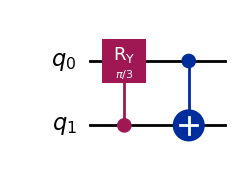

In [4]:
def amplitude_damping_gate(_noise=None):
    """
    Restituisce un gate personalizzato che rappresenta
    l'implementazione unitaria del canale amplitude damping.
    
    Restituisce:
        Gate: un gate "AmpDamp" personalizzato da applicare a 2 qubit
    """
    qc = AmplitudeDampingConvenzioneClassica(noise_to_theta(_noise))
    gate = qc.to_gate(label="AmpDamp")
    
    return gate
# circuito esempio con questo canale
example = QuantumCircuit(2)

# applico il gate che simula il canale amplitude damping
example.append(amplitude_damping_gate(theta_to_noise(np.pi/3)), [0 ,1])
# example_q.append(amplitude_damping_gate_qi(), [0 ,1])

display(Latex(r"Matrice del circuito (parametro = $\frac{\pi}{3}$)"))

# permette di trasformare il circuito nella sua rappresentazione di operatore
display(Operator.from_circuit(example).draw("latex")) 

# mostra il circuito decomposto
display(example.decompose().draw("mpl"))

## Convenzione Qiskit

### Definisco il canale Amplitude Damping

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

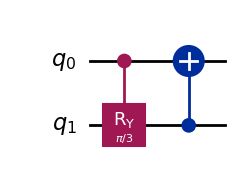

In [5]:
def amplitude_damping_gate_qi(_noise=None):
    """
    Restituisce un gate personalizzato che rappresenta
    l'implementazione unitaria del canale amplitude damping
    su due qubit (sistema e ambiente) nella convezione di qiskit.

    Parametri:
        _noise (float or Parameter): valore tra 0 e 1 che viene convertito in angolo per la rotazione Ry
            ! se non viene istanziato allora di default è Parameter('η')

    Restituisce:
        Gate: un gate "AmpDamp qi" personalizzato da applicare a 2 qubit
    """
    # Crea un circuito con 2 qubit: qubit 1 = S_1, qubit 0 = E_1 (Ambiente)
    qc = QuantumCircuit(2, name="Amplitude Damping Model Qi")

    # basta invertire il collegamento del canale definito precedentemente
    qc.append(amplitude_damping_gate(_noise),[1,0])

    qc = qc.decompose()

    # Converte in un Custom Gate
    gate = qc.to_gate(label="AmpDamp qi")
    
    return gate

# circuito esempio con questo canale
example_q = QuantumCircuit(2)

# applico il gate che simula il canale amplitude damping
example_q.append(amplitude_damping_gate_qi(theta_to_noise(np.pi/3)), [0 ,1])
# example_q.append(amplitude_damping_gate_qi(), [0 ,1])

display(Latex(r"Matrice del circuito (parametro = $\frac{\pi}{3}$)"))

# permette di trasformare il circuito nella sua rappresentazione di operatore
display(Operator.from_circuit(example_q).draw("latex")) 

# mostra il circuito decomposto
display(example_q.decompose().draw("mpl"))

### Definisco il circuito per la creazione di uno stato misto

Matrice densità ridotta (target qubit):


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

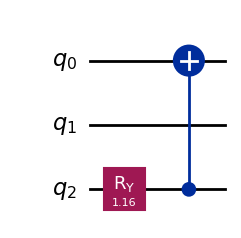

In [6]:
def getAncillaParametrized(_alpha=None):
    """
    Costruisce un gate quantistico che inizializza un qubit target (qubit 0)
    in uno stato misto con popolazioni [1 - α, α] tramite entanglement con un’ancilla (qubit 2).

    Parametri:
        _alpha (float o Parameter): probabilità di osservare il qubit target nello stato |1⟩
                                     dopo tracciatura dell’ancilla.
                                     Può essere un valore numerico o un parametro simbolico.

    Restituisce:
        Gate: un gate custom che può essere inserito in un circuito per inizializzare
              lo stato del qubit target in modo controllato.
        !! nel cubit 0,1 abbiamo uno stato iniziale del tipo q1 ⊗ rho_sis,
        !! mentre nel qubit 1,2 abbiamo uno stato del tipo rho_sis ⊗ q1.
    """
    An = AncillaInitializationCircuit(BADC.noise_to_theta(_alpha))
    # crea due stati uno q1 = rho_env ⊗ q0 = rho_sis (conv. qiskit),
    # mentre l'altro è q2 = rho_sis ⊗ q1 = rho_env (conv. classica).

    # converte in un gate
    gate = An.to_gate(label="AncInitilizeState")

    return gate

# alpha = Parameter('α')
alpha = 0.3
example_a = QuantumCircuit(3)
example_a.append(getAncillaParametrized(alpha), [0,2])

print("Matrice densità ridotta (target qubit):")
display(partial_trace(DensityMatrix.from_label("000").evolve(example_a), [0]).draw("latex"))
display(partial_trace(DensityMatrix.from_label("000").evolve(example_a), [2]).draw("latex"))
display(example_a.decompose().draw("mpl"))

### Definisco il canale completo senza misura

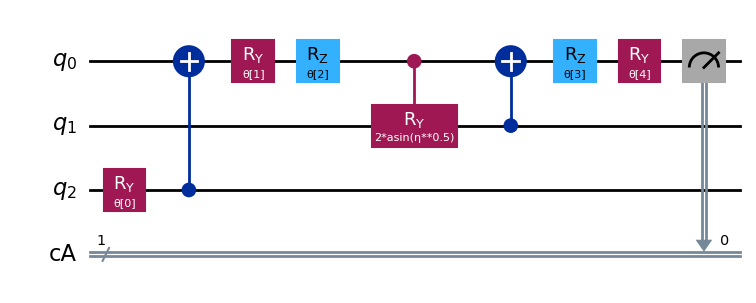

In [7]:
thetas = ParameterVector("θ", 5)
noise = Parameter("η")
qc_ch = QuantumCircuit(3, 0)
qc_ch.add_register(ClassicalRegister(1,"cA"))
# qc_ch.append(getAncillaParametrized(thetas[0]),[0,2])
qc_ch.append(AncillaInitializationCircuit(thetas[0]),[0,2])
qc_ch.ry(thetas[1], 0)
qc_ch.rz(thetas[2], 0)
qc_ch.append(amplitude_damping_gate_qi(noise),[0,1])
qc_ch.rz(thetas[3], 0)
qc_ch.ry(thetas[4], 0)
qc_ch.measure(0,0)
# qc_ch = qc_ch.decompose(["AncInitilizeState","AmpDamp qi"])
qc_ch = qc_ch.decompose(["AncillaInit","AmpDamp qi"])
display(qc_ch.draw("mpl"))

### definisco il canale per A e B con misure per l'ottimizzazione

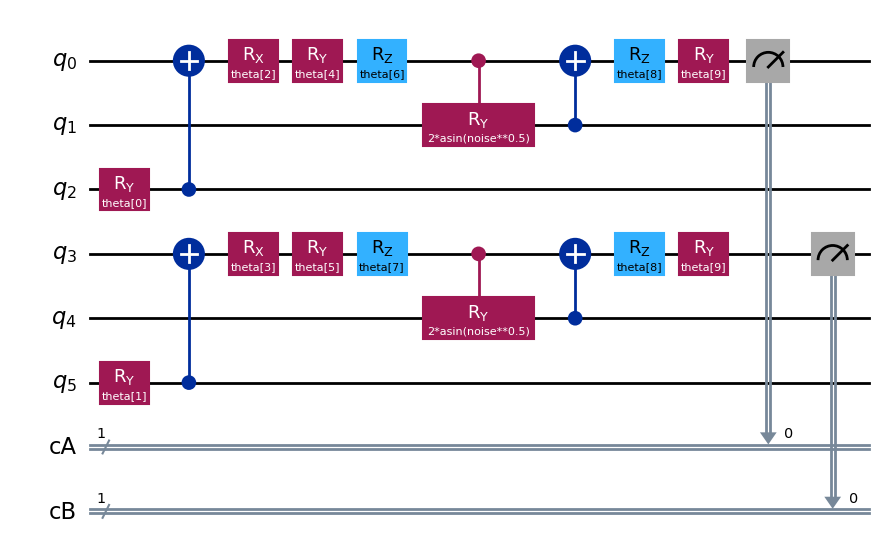

In [8]:
radice, risultati, visualizzazione = crea_cartelle_risultati(project_root)
thetas = ParameterVector("theta", 10)
noise = Parameter("noise")
qc = QuantumCircuit(6)
qc.add_register(ClassicalRegister(1,"cA"))
qc.add_register(ClassicalRegister(1,"cB"))

qc.compose(AncillaInitializationCircuit(thetas[0]),[0,2],inplace = True)
# qc.ry(thetas[0], 2)
# qc.cx(2,0)                   
qc.compose(AncillaInitializationCircuit(thetas[1]),[3,5],inplace = True)                         
# qc.ry(thetas[1], 5)
# qc.cx(5,3)

qc.rx(thetas[2], 0)
qc.rx(thetas[3], 3)

qc.ry(thetas[4], 0)
qc.ry(thetas[5], 3)

qc.rz(thetas[6], 0)
qc.rz(thetas[7], 3)

qc.compose(AmplitudeDampingConvenzioneQiskit(Utils.TwoAsinSqrt(noise)),[0,1],inplace=True)
# qc.cry(2*(noise**0.5).arcsin(),0,1)
# qc.cx(1,0)
qc.compose(AmplitudeDampingConvenzioneQiskit(Utils.TwoAsinSqrt(noise)),[3,4],inplace= True)

# qc.cry(2*(noise**0.5).arcsin(),3,4)
# qc.cx(4,3)

qc.rz(thetas[8], 0)
qc.rz(thetas[8], 3)

qc.ry(thetas[9], 0)
qc.ry(thetas[9], 3)

qc.measure(0,0)
qc.measure(3,1)
salva_plot_png(qc.draw("mpl"), base_name = "circuito_ottimizzazione", base_dir=radice,subfolder=risultati, _create=True)
display(qc.draw("mpl"))

### Per il canale doppio, usare il seguente modello

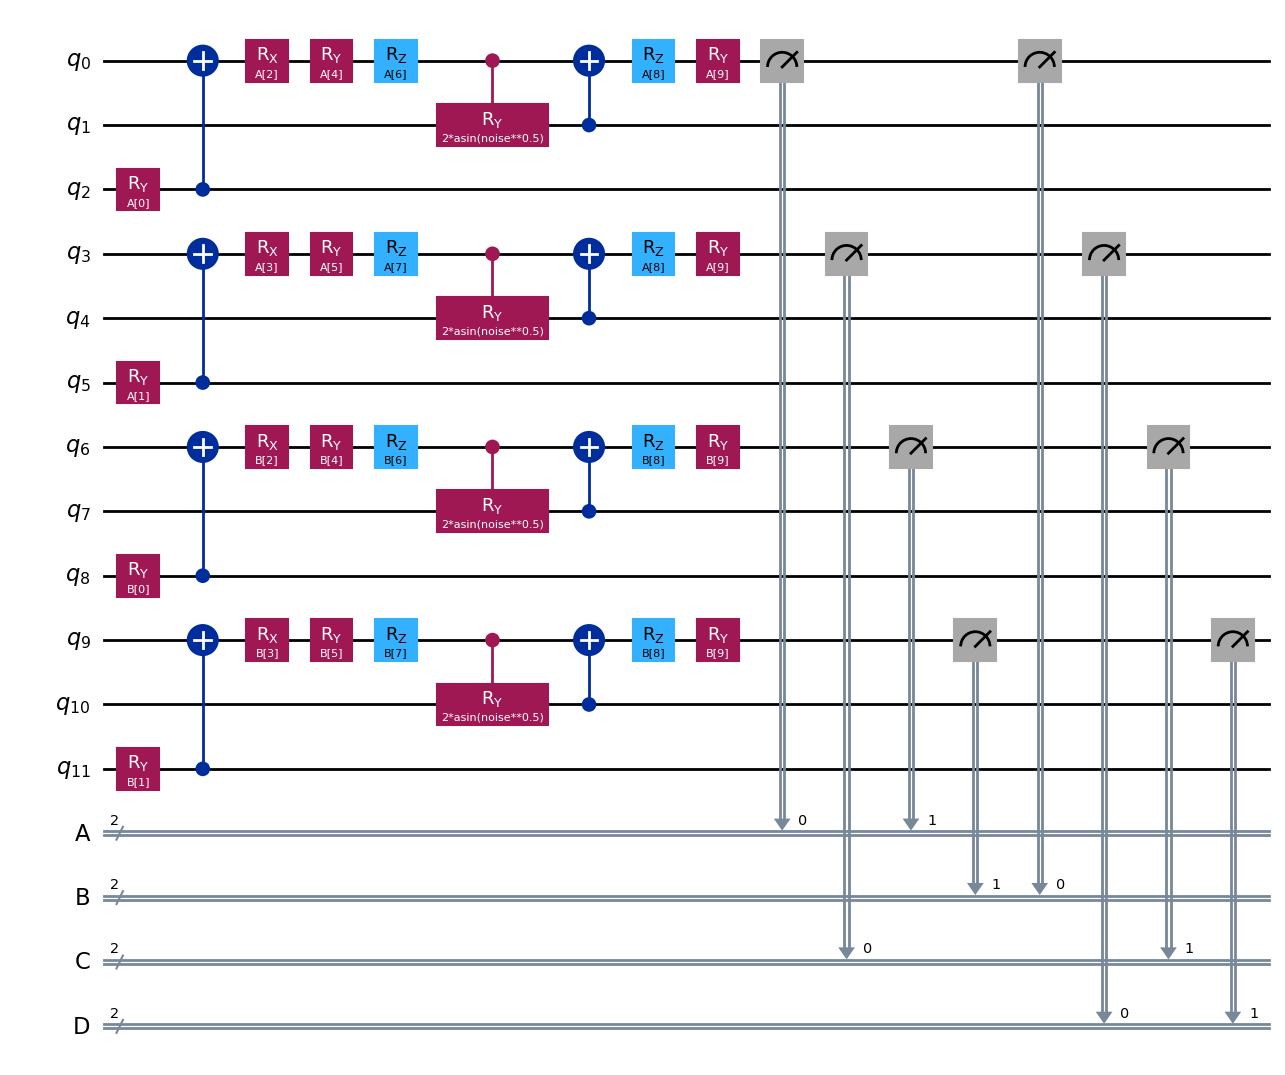

In [41]:
import string
num_channels = 2
qc_be_opt = QuantumCircuit(qc.num_qubits * num_channels)
letter_uppercase = list(string.ascii_uppercase)
num_meas_of_single_channels = qc.num_clbits
num_qubit_of_single_channels = qc.num_qubits
label_params = {}
keys_sorted = []
change_param = qc.parameters
change_param.remove(noise)
for i in range(num_channels):
    let = letter_uppercase[i]
    qc_be_opt.add_register(ClassicalRegister(num_meas_of_single_channels,"c"+let))
    #qc_be_opt.add_register(ClassicalRegister(2,"cB"))
    param = ParameterVector(let, len(change_param))
    #paramsB = ParameterVector("B", len(param_circuit))
    qc_t = qc.assign_parameters({change_param[j]:param[j] for j in range(len(change_param))})
    #qc_b = qc.assign_parameters({new_param_circuit[i]:paramsB[i] for i in range(len(param_circuit))})
    qc_be_opt.compose(qc_t,
                    [j+i*qc_t.num_qubits for j in range(qc_t.num_qubits)],
                    [j+i*num_meas_of_single_channels for j in range(num_meas_of_single_channels)],
                    inplace=True)
    label_params.update({let : param})
    keys_sorted.append(let)
qc_be_opt.remove_final_measurements()
qc_be_opt.add_register(ClassicalRegister(2,"A"))
qc_be_opt.add_register(ClassicalRegister(2,"B"))
qc_be_opt.add_register(ClassicalRegister(2,"C"))
qc_be_opt.add_register(ClassicalRegister(2,"D"))
qc_be_opt.measure(0,[0,2])
qc_be_opt.measure(3,[4,6])

qc_be_opt.measure(6,[1,5])
qc_be_opt.measure(9,[3,7])

qc_be_opt.draw("mpl")
display(qc_be_opt.draw("mpl"))

# Fase 2: evoluzione del circuito e misura con lo stato iniziale misto definito, e esempi di simulazioni

## Simulazioni

### Aggiungo al circuito la misura e il bit di registo delle misurazioni (uso il circuito con convenzione classica)

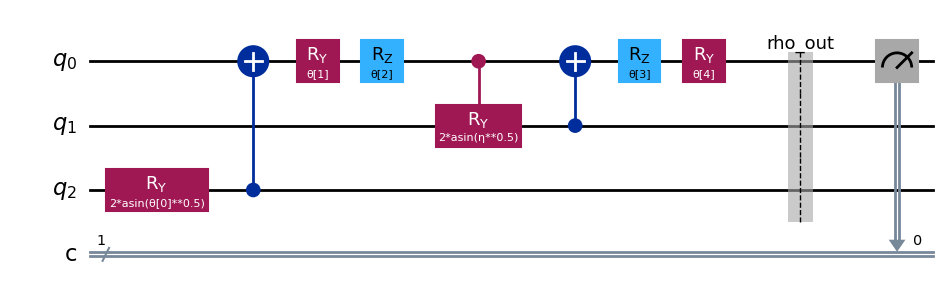

Risultati di misura:
{'0': 52209, '1': 47791}
stato finale prima della misura


<IPython.core.display.Latex object>

In [12]:
sim = AerSimulator(method='density_matrix')

# preparo un circuito per un esempio di simulazione
qc_example = QuantumCircuit(3,1)
qc_example.compose(qc_ch, [0,1,2],inplace=True)
qc_example.save_density_matrix(label = "rho_out")
qc_example.measure(0,0)
display(qc_example.draw("mpl"))

# preparo un dizionario di parametri di esempio
param_values = {
    "θ[0]": 0.3,
    "θ[1]": np.pi/6,
    "θ[2]": np.pi/4,
    "θ[3]": np.pi/3,
    "θ[4]": np.pi/2,
    "η"   : theta_to_noise(0)
}
# effettuo la traduzione dei parametri
qc_trans = transpile(qc_example.assign_parameters(param_values), sim, optimization_level=0)
# eseguo la simulazione
result = sim.run(circuits=qc_trans,shots = 100000).result()
print("Risultati di misura:")
print(result.get_counts())
print("stato finale prima della misura")
display(partial_trace(result.data(0)['rho_out'],[1,2]).draw("latex"))


### Simulazione con Ancilla convenzione qiskit su simulazione con rumore di un backend reale, uso di SamplerV2

In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService
from dotenv import load_dotenv
import os

# Carica il file .env nella sessione
load_dotenv()
service = QiskitRuntimeService(channel="ibm_quantum_platform",token=os.getenv("IBM_TOKEN"),instance=os.getenv("INSTANCE"))
backend_name = "ibm_brisbane"
backend = service.backend(backend_name)

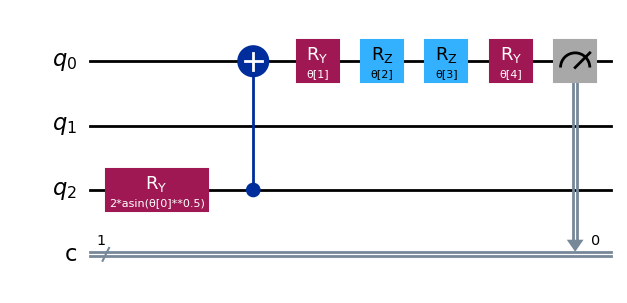

{'0': 52627, '1': 47373}


In [11]:
# imposto il simulatore sul backend che ho ottenuto
sim = BackendLikeSimulator(backend)
thet = ParameterVector("θ", 5)
# preparo un circuito per un esempio di simulazione
qc_example = QuantumCircuit(3,1)
qc_example.append(getAncillaParametrized(thet[0]),[0,2])
qc_example.ry(thet[1], 0)
qc_example.rz(thet[2], 0)
#qc_example.append(amplitude_damping_gate_qi(noise),[0,1])
qc_example.rz(thet[3], 0)
qc_example.ry(thet[4], 0)
qc_example = qc_example.decompose(["AncInitilizeState","AmpDamp qi"])
qc_example.measure(0,0)
display(qc_example.draw("mpl"))

param_values = {
    "θ[0]" : 0.3,
    "θ[1]": np.pi/6,
    "θ[2]": np.pi/4,
    "θ[3]": np.pi/3,
    "θ[4]": np.pi/2,
    # "η"   : theta_to_noise(np.pi/3),
}

result = sim.run([(qc_example,param_values, 100000)])
print(result[0].data.c.get_counts())

# Fase 3: Ottimizzazione del circuito con SciPy

### Funzioni ausiliari

In [9]:
# def normalize_counts(counts):
#     """
#     Aggiunge le chiavi '0' e '1' con valore 0 se mancanti.
#     """
#     return Utils.normalize_counts(counts)

def cost_function(counts):
    """
    Calcola la stima della probabilità di errore media degli esiti di misura utilizzando il metodo della massima verosimiglianza.

    Parametri:
    -----------
    counts : list of dict
        Lista di dizionari. Ogni dizionario rappresenta i conteggi di misura
        per una diversa classe (o esperimento), con chiavi '0' e '1' che indicano
        il numero di volte in cui ciascun risultato è stato ottenuto.

        Esempio:
            counts = [
                {'0': 900, '1': 100},   # Esperimento A
                {'0': 200, '1': 800}    # Esperimento B
            ]

    Ritorna:
    --------
    float
        Valore della funzione costo
    """
    return Utils.cost_function(counts)

def merge_dict(dicts):
    """
    Unisce una lista di dizionari in un singolo dizionario, in cui i valori associati
    a ciascuna chiave sono raccolti in una lista ordinata.

    Parametri:
    -----------
    dicts : list of dict
        Una lista di dizionari, tutti con lo stesso insieme di chiavi (o parzialmente sovrapposti).
        Esempio:
            [{'a': 1, 'b': 2}, {'a': 3, 'b': 4}, {'a': 5, 'b': 6}]

    Ritorna:
    --------
    dict
        Un dizionario in cui ogni chiave è associata a una lista di valori
        raccolti nell'ordine dei dizionari originali.
        Esempio output:
            {'a': [1, 3, 5], 'b': [2, 4, 6]}
    """
    return Utils.merge_dict(dicts)

### Funzione wrapper

In [10]:
def cost_wrapper_scipy(theta_vector,qc,shots,mode : AbstractSimulator,cost_history):
    # mettere la gestione dei parametri in un metodo del circuito stesso
    if not(len(theta_vector) == qc.num_parameters): 
        f"Attesi {qc.num_parameters} parametri"
    result = mode.run([(qc, theta_vector, shots)])
    #counts = result[0].data.c.get_counts()
    # Estrae i conteggi delle misure per ogni esperimento, che dovrebbero essere 2.
    # Passa questi conteggi alla funzione costo, che valuta quanto sono statisticamente separabili.
    # print([ i.data[c].get_counts() for i in result for c in i.data])
    cost = cost_function([ i.data[c].get_counts() for i in result for c in i.data])
    cost_history.append([cost] + list(theta_vector))
    #print([cost] + list(theta_vector))
    return cost
met0 = "COBYQA"
met1 = "COBYQA"
radice, risultati, visualizzazione = crea_cartelle_risultati(project_root)


### ottimizzazione del circuito ricercando soluzioni locali ottime

C:\Users\rem.gabryldellarosa\OneDrive - Universita degli Studi Roma Tre\Desktop\Tesi\quantum-amplitude-damping-channel\result\risultati_ad_senza_entanglement\risultati
C:\Users\rem.gabryldellarosa\OneDrive - Universita degli Studi Roma Tre\Desktop\Tesi\quantum-amplitude-damping-channel\result\risultati_ad_senza_entanglement\risultati\risultati_ottimizzazione
C:\Users\rem.gabryldellarosa\OneDrive - Universita degli Studi Roma Tre\Desktop\Tesi\quantum-amplitude-damping-channel\result\risultati_ad_senza_entanglement\risultati\visualizzazione_risultati_sfera_bloch
[4.60534999 1.15554591 3.60308611 5.42670186 0.34169786 4.56979679
 6.06267518 4.72064505 5.43415991 5.43074841]


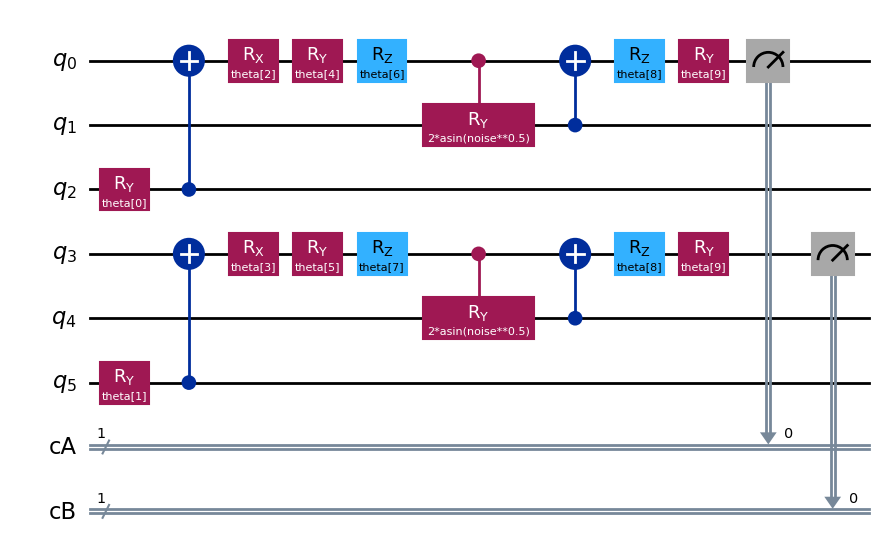

Starting the optimization procedure.
Initial trust-region radius: 1.0.
Final trust-region radius: 0.001.
Maximum number of function evaluations: 5000.
Maximum number of iterations: 200.

cost_wrapper_scipy([ 4.605e+00  1.156e+00 ...  5.283e+00  5.283e+00]) = 0.43333333333333335
cost_wrapper_scipy([ 5.605e+00  1.156e+00 ...  5.283e+00  5.283e+00]) = 0.3967777777777778
cost_wrapper_scipy([ 4.605e+00  2.156e+00 ...  5.283e+00  5.283e+00]) = 0.3931111111111112
cost_wrapper_scipy([ 4.605e+00  1.156e+00 ...  5.283e+00  5.283e+00]) = 0.4101111111111111
cost_wrapper_scipy([ 4.605e+00  1.156e+00 ...  5.283e+00  5.283e+00]) = 0.4464444444444444
cost_wrapper_scipy([ 4.605e+00  1.156e+00 ...  5.283e+00  5.283e+00]) = 0.4315555555555556
cost_wrapper_scipy([ 4.605e+00  1.156e+00 ...  5.283e+00  5.283e+00]) = 0.41755555555555557
cost_wrapper_scipy([ 4.605e+00  1.156e+00 ...  5.283e+00  5.283e+00]) = 0.42466666666666664
cost_wrapper_scipy([ 4.605e+00  1.156e+00 ...  5.283e+00  5.283e+00]) = 0.43633333

In [11]:
radice, risultati, visualizzazione = crea_cartelle_risultati(project_root)
qc_be_opt = qc
par = qc_be_opt.parameters
par.remove(noise)
#qc_be_opt.assign_parameters({par[18]:par[8], par[19]:par[9],par[38]:par[28],par[39]:par[29]},inplace=True)
print(radice)
print(risultati)
print(visualizzazione)
x0 = np.random.uniform(0, 2 * np.pi, size=qc_be_opt.num_parameters-1)
noises = np.linspace(0, 0.9, 5)
#noises=[0.675]
print(x0)
met0 = "COBYQA"
met1 = "COBYQA"
#met1 = ""
all_simulation = []
mode = IdealSimulator()
salva_plot_png(qc_be_opt.draw("mpl"), base_name = "circuito_ottimizzazione", base_dir=radice,subfolder=risultati, _create=True)
display(qc_be_opt.draw("mpl"))
for n in noises:
    start_time = time.time()
    cost_history = []
    qc_set_noise = qc_be_opt.assign_parameters({noise : n})
    cost_wrapper_scipy(x0,qc_set_noise, 10000, mode, cost_history)
    result = minimize(
        cost_wrapper_scipy,
        x0,
        args=(qc_set_noise, 4500, mode, cost_history),
        method=met0,
        bounds=np.array(list([(-0*np.pi, 2*np.pi)]*qc_set_noise.num_parameters)),
        tol = 0.001,
        options={
                "maxiter": 200, 
                "disp": True,
                }
    )
    all_simulation.append((result,cost_history,n))
    end_time = time.time()
    execution_time = end_time - start_time
    print(result)
    print(f"""print optimal parameters: {result.x}""")
    print(f"""Number of iterations: {result.nfev}""")
    print(f"""Time (s): {execution_time}""")
    print(f"""result: {result.fun}""")
    
x0_min = []
c_m = 1
for (r,_,n) in all_simulation:

    prob_min_err_single_channel_teorico_no_ent = 0.5 * (1-np.sqrt(1-n))
    d  =  np.sqrt(np.square(r.fun - prob_min_err_single_channel_teorico_no_ent))
    if (d < c_m and n!=0):
        x0_min = r.x
        c_m = d

for i in range(len(all_simulation)):
    _,cost_history,n = all_simulation[i]
    start_time = time.time()
    qc_set_noise = qc_be_opt.assign_parameters({noise : n})
    cost_wrapper_scipy(x0_min,qc_set_noise, 10000, mode, cost_history)
    result = minimize(
        cost_wrapper_scipy,
        x0_min,
        args=(qc_set_noise, 200000, mode, cost_history),
        method=met0,
        bounds=np.array(list([(-0*np.pi, 2*np.pi)]*qc_set_noise.num_parameters)),
        tol = 0.001,
        options={
                "maxiter": 250, 
                "disp": True,
                }
    )
    all_simulation[i] = ((result,cost_history,n))
    end_time = time.time()
    execution_time = end_time - start_time
    print(result)
    print(f"""print optimal parameters: {result.x}""")
    print(f"""Number of iterations: {result.nfev}""")
    print(f"""Time (s): {execution_time}""")
    print(f"""result: {result.fun}""")

### Salva dati in un file formato {"input" : x0, "results" : all_simulations}

In [28]:
import pickle

with open(radice+"/data.pkl", "wb") as f:
    pickle.dump({"input":x0,"results":all_simulation}, f)

## Leggi dati da un file 

In [11]:
import pickle

with open(radice+"/data.pkl", "rb") as f:
    data = pickle.load(f)
x0 = data["input"]
all_simulation = data["results"]

### plot risultati

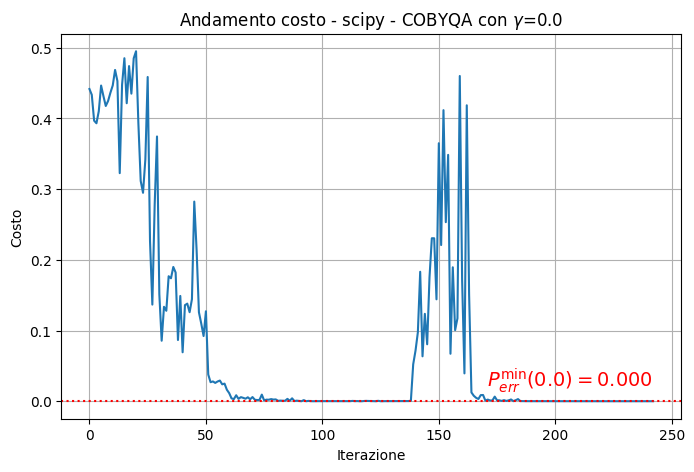

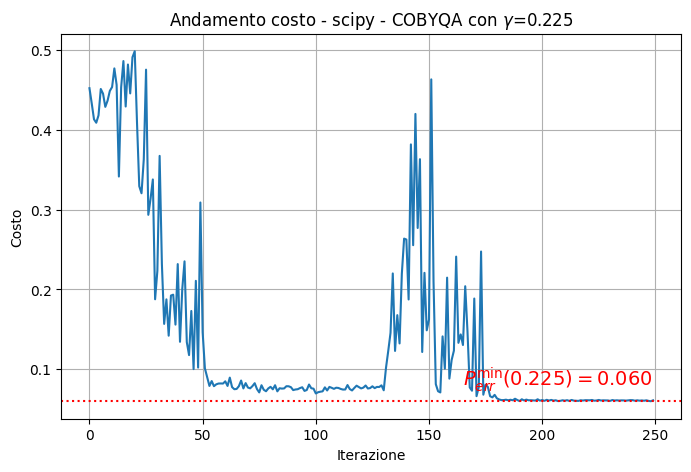

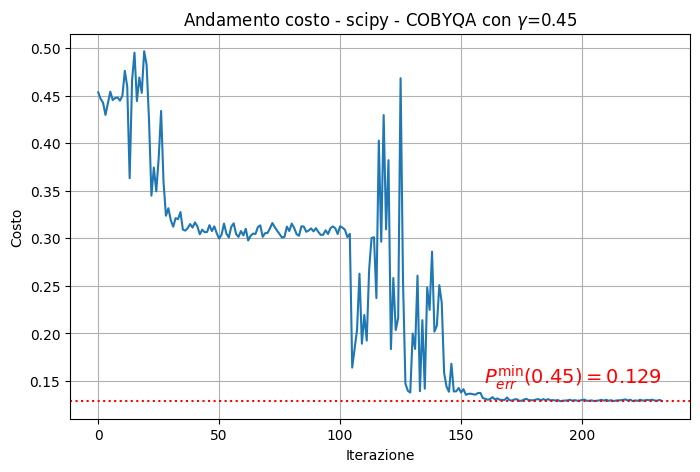

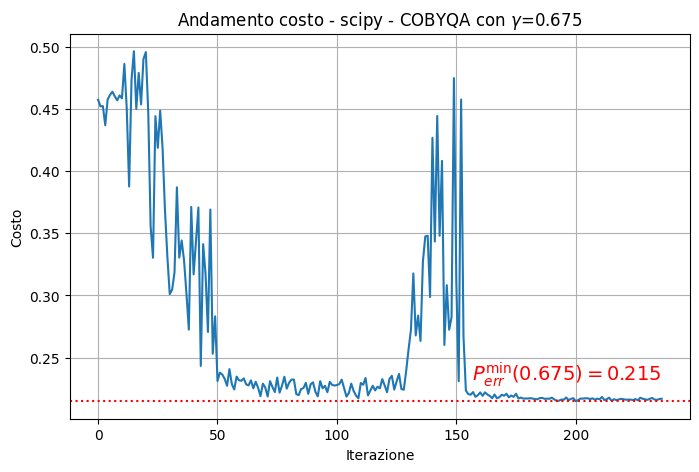

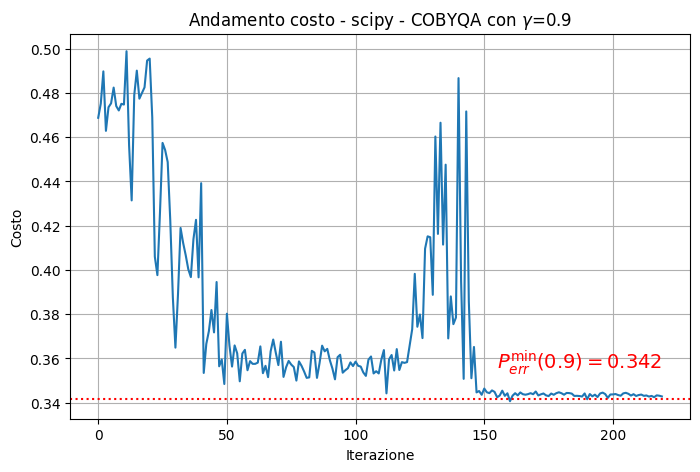

In [12]:
import matplotlib.pyplot as plt
for elem in all_simulation:
    result, cost_history, n = elem
    cost, param = ( lambda arr: (
        arr[:, 0].tolist(),           # lista dei costi
        arr[:, 1:].tolist()           # lista delle liste dei parametri
    ))(np.array(cost_history))
    prob_min_err_single_channel_teorico = 0.5 * (1-np.sqrt(1-n))
    param = np.array(param)
    pr = [thetas[0].name + " A", 
          thetas[2].name + " A", 
          thetas[4].name + " A", thetas[6].name + " A", thetas[1].name + " B",
          thetas[3].name +" B",
          thetas[5].name + " B", thetas[7].name +" B", thetas[8].name +"A e B", thetas[9].name + "A e B"]
    # pr = [p.name for k in keys_sorted for p in label_params[k]]
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(cost)
    ax.set_xlabel("Iterazione")
    ax.set_ylabel("Costo")
    ax.set_title(fr"Andamento costo - scipy - {met0} con $\gamma$={n}")
    ax.grid(True)
    ax.axhline(y=prob_min_err_single_channel_teorico, color="red", linestyle=":")
    ax.text(len(cost)-1, prob_min_err_single_channel_teorico+ 0.01, 
            fr"$P_{{err}}^\min ({n}) = {prob_min_err_single_channel_teorico:.3f}$",
            color="red", va="bottom", ha="right", fontsize = 14)
    # # Aggiunge i valori finali fuori dal grafico, ad esempio in basso
    # initial_values_text = "\n".join([
    #     f"{pr[i]} = {x0[i]:.8f} rad ({x0[i]/(2*np.pi):.3f} 2π)"
    #     for i in range(len(x0))
    # ])

    # fig.text(0.02, -0.25, f"Parametri iniziali:\n{initial_values_text}",
    #         fontsize=10, va='top', ha='left')

    # plt.tight_layout()
    # #display(fig)
    salva_plot_png(fig, f"costo_damping_{n}", radice, risultati, _create=True, name_create=f"damping_{n}")
    

    # fig, ax = plt.subplots(figsize=(8, 5))

    # # Traccia l'andamento dei parametri
    # for i in range(param.shape[1]):
    #     ax.plot(param[:, i] / (2*np.pi), label=f"{pr[i]} / 2π")
    #     ax.scatter(len(param) - 1, result.x[i] / (2*np.pi), color='black', marker='x', s=60)

    # ax.set_xlabel("Iterazione")
    # ax.set_ylabel("Parametri normalizzati in 2π")
    # ax.set_title(f"Andamento parametri - scipy-{met0}+{met1} con η={n}")
    # ax.legend()
    # ax.grid(True)

    # # Aggiunge i valori finali fuori dal grafico, ad esempio in basso
    # final_values_text = "\n".join([
    #     f"{pr[i]} = {result.x[i]:.8f} rad ({result.x[i]/(2*np.pi):.3f} 2π)"
    #     for i in range(len(result.x))
    # ])

    # fig.text(0.02, -0.25, f"Parametri ottimali trovati:\n{final_values_text}",
    #         fontsize=10, va='top', ha='left')

    # plt.tight_layout()
    # salva_plot_png(fig,f"parametri_damping_{n}",radice,risultati,_create = True,name_create=f"damping_{n}")

### Plot su sfera di Bloch

None

None

None

None

None

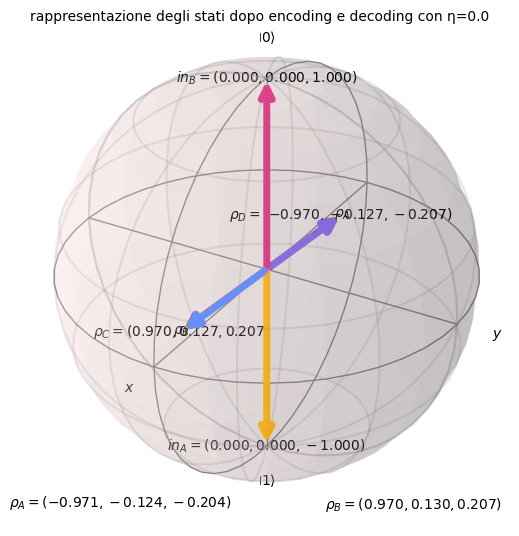

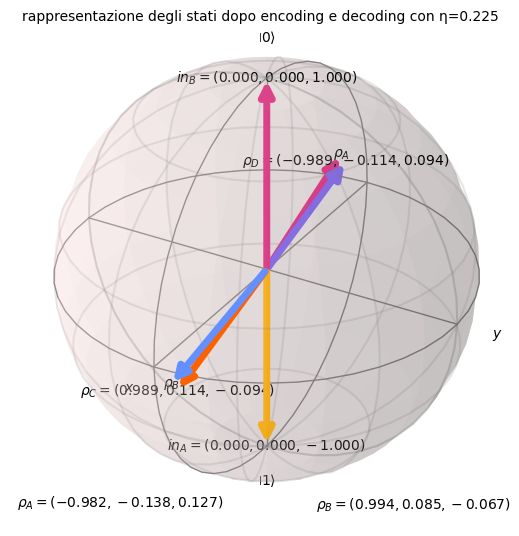

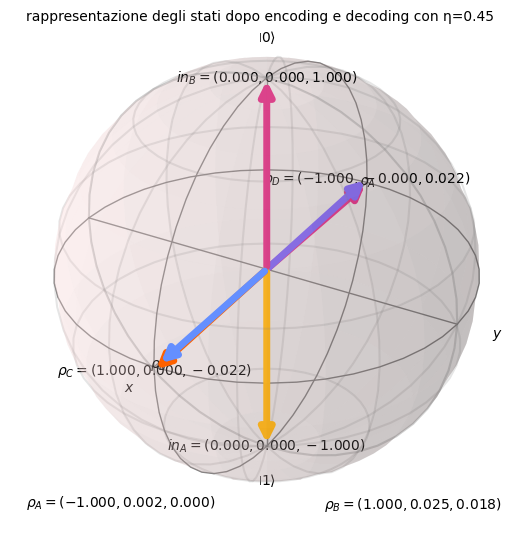

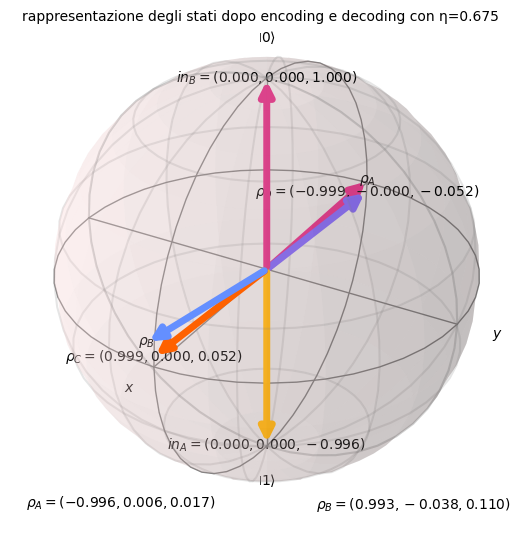

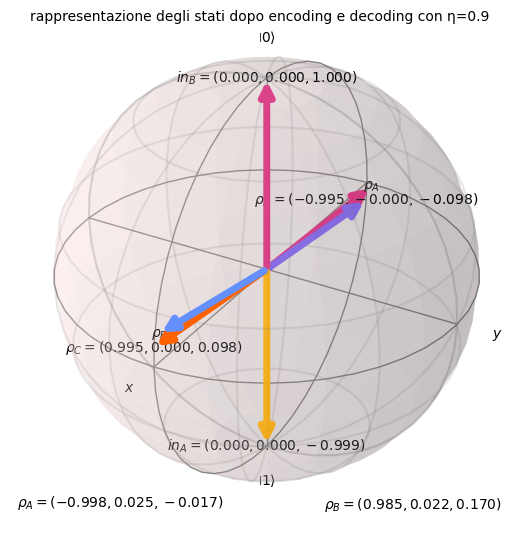

In [13]:

for elem in all_simulation:
    result, cost_history, n = elem
    qc_visualize = QuantumCircuit(3)
    qc_visualize.ry(thetas[0], 2)
    qc_visualize.cx(2,0)
    qc_visualize1 = QuantumCircuit(3)
    qc_visualize1.ry(thetas[0], 2)
    qc_visualize1.cx(2,0)
    bound_in_a = qc_visualize.assign_parameters({thetas[0]: (result.x[0])})
    bound_in_b = qc_visualize1.assign_parameters({thetas[0]: (result.x[1])})
    state_in_a = partial_trace(DensityMatrix.from_label("000").evolve(bound_in_a),[1,2])
    state_in_b = partial_trace(DensityMatrix.from_label("000").evolve(bound_in_b),[1,2])
    # display(state_in_a.draw("latex"))
    # display(state_in_b.draw("latex"))
    qc_visualize.rx(thetas[1], 0)
    qc_visualize.ry(thetas[2], 0)
    qc_visualize.rz(thetas[3], 0)
    
    qc_visualize1.ry(thetas[1], 0)
    qc_visualize1.rz(thetas[2], 0)
    
    #qc_visualize.append(amplitude_damping_gate_qi(n),[0,1])
    # qc_visualize1.append(amplitude_damping_gate_qi(-n),[0,1])

    bound_a = qc_visualize.assign_parameters({thetas[0]: result.x[0],
                                              thetas[1]:result.x[2],
                                               thetas[2]:result.x[4],thetas[3]:result.x[6]})
    bound_b = qc_visualize.assign_parameters({thetas[0]: result.x[1],
                                               thetas[1]:result.x[3],
                                               thetas[2]:result.x[5], thetas[3]:result.x[7]})

    bound_c = qc_visualize1.assign_parameters({thetas[0]: noise_to_theta(0), thetas[1]:-result.x[9],thetas[2]:-result.x[8]})
    bound_d = qc_visualize1.assign_parameters({thetas[0]: noise_to_theta(1), thetas[1]:-result.x[9],thetas[2]:-result.x[8]})


    state_a = partial_trace(DensityMatrix.from_label("000").evolve(bound_a),[1,2])
    state_b = partial_trace(DensityMatrix.from_label("000").evolve(bound_b),[1,2])
    state_c = partial_trace(DensityMatrix.from_label("000").evolve(bound_c),[1,2])
    state_d = partial_trace(DensityMatrix.from_label("000").evolve(bound_d),[1,2])


    # display(state_a.draw("text"))
    # display(state_c.draw("text"))
    # display(state_d.draw("text"))

    from qiskit.visualization.bloch import Bloch
    import numpy as np

    from qiskit.visualization import *
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # Ottieni il Bloch vector (x, y, z)
    bloch_vect_enc_in_a = [state_in_a._expectation_value_pauli(Pauli(p)) for p in ['X', 'Y', 'Z']]
    bloch_vect_enc_in_b = [state_in_b._expectation_value_pauli(Pauli(p)) for p in ['X', 'Y', 'Z']]

    bloch_vect_enc_a = [state_a._expectation_value_pauli(Pauli(p)) for p in ['X', 'Y', 'Z']]
    bloch_vect_enc_b = [state_b._expectation_value_pauli(Pauli(p)) for p in ['X', 'Y', 'Z']]
    bloch_vect_enc_c = [state_c._expectation_value_pauli(Pauli(p)) for p in ['X', 'Y', 'Z']]
    bloch_vect_enc_d = [state_d._expectation_value_pauli(Pauli(p)) for p in ['X', 'Y', 'Z']]


    b = Bloch(figsize=[5,5],font_size=10)
    b.add_vectors([bloch_vect_enc_a, bloch_vect_enc_b, bloch_vect_enc_c,bloch_vect_enc_d,bloch_vect_enc_in_a,bloch_vect_enc_in_b])  # aggiunge il vettore
    # Aggiungi annotazioni
    x,y,z = bloch_vect_enc_a
    b.add_annotation(bloch_vect_enc_a,f"$ \\rho_A $")
    b.add_annotation([1,-0.2,-0.8],f"$ \\rho_A = ({x:.3f},{y:.3f},{z:.3f}) $")
    x,y,z = bloch_vect_enc_b
    b.add_annotation(bloch_vect_enc_b,f"$ \\rho_B $")
    b.add_annotation([1,1.3,-0.29],f"$ \\rho_B =  ({x:.3f},{y:.3f},{z:.3f}) $")
    x,y,z = bloch_vect_enc_c
    #b.add_annotation(bloch_vect_enc_c,f"$ \\rho_B $")
    b.add_annotation(bloch_vect_enc_c,f"$ \\rho_C =  ({x:.3f},{y:.3f},{z:.3f}) $")
    x,y,z = bloch_vect_enc_d
    #b.add_annotation(bloch_vect_enc_c,f"$ \\rho_B $")
    b.add_annotation(bloch_vect_enc_d,f"$ \\rho_D =  ({x:.3f},{y:.3f},{z:.3f}) $")
    x,y,z = bloch_vect_enc_in_a
    #b.add_annotation(bloch_vect_enc_c,f"$ \\rho_B $")
    b.add_annotation(bloch_vect_enc_in_a,f"$ in_A =  ({x:.3f},{y:.3f},{z:.3f}) $")
    x,y,z = bloch_vect_enc_in_b
    #b.add_annotation(bloch_vect_enc_c,f"$ \\rho_B $")
    b.add_annotation(bloch_vect_enc_in_b,f"$ in_B =  ({x:.3f},{y:.3f},{z:.3f}) $")

    # Titolo personalizzato
    b.render(title = f"rappresentazione degli stati dopo encoding e decoding con η={n}")
    #display(b.fig)
    salva_plot_png(b.fig, f"bloch_qi_damping_{n}",radice,visualizzazione,_create = True, name_create = f"damping_{n}")

    def plot_multiple_bloch_vectors(bloch_vectors, name_vectors = None, title = None, noise = 0 ):
        """
        bloch_vectors: lista di tuple/liste [(x1,y1,z1), (x2,y2,z2), ...]
        """
        if name_vectors == None or len(name_vectors) != len(bloch_vectors) :
            name_vectors = [f"Vettore {i}" for i in range(len(bloch_vectors))]

                

        # Mesh della sfera
        u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:25j]
        xs = np.cos(u)*np.sin(v)#*np.sqrt(1-noise)
        ys = np.sin(u)*np.sin(v)#*np.sqrt(1-noise)
        zs = np.cos(v)#*(1-noise) + noise

        fig = make_subplots(
            rows=2, cols=1,
            specs=[[{"type": "surface"}], [{"type": "table"}]],
            row_heights=[0.65, 0.55],
            vertical_spacing=0.00,
        )

        # Sfera
        fig.add_trace(go.Surface(
            x=xs, y=ys, z=zs,
            opacity=0.2, showscale=False, colorscale='Blues'
        ), row=1, col=1)

        # Dati per tabella
        labels = []
        x_vals, y_vals, z_vals = [], [], []

        # Aggiungi ogni vettore
        for i, (x, y, z) in enumerate(bloch_vectors):
            fig.add_trace(go.Scatter3d(
                x=[0, x], y=[0, y], z=[0, z],
                mode='lines+markers',
                marker=dict(size=4),
                line=dict(width=6),
                name=name_vectors[i]
            ), row=1, col=1)

            labels.append(name_vectors[i])
            x_vals.append(f"{x:.5f}")
            y_vals.append(f"{y:.5f}")
            z_vals.append(f"{z:.5f}")

        # Tabella
        fig.add_trace(go.Table(
            header=dict(values=["Vettore", "X", "Y", "Z"],
                        fill_color='lightgrey', align='center',
                        font=dict(size=16, color='black') ),
            cells=dict(values=[labels, x_vals, y_vals, z_vals],
                    fill_color='white', align='center',
                    height=40,
                    font=dict(size=16, color='black'),
                    )  
        ), row=2, col=1)

        # Layout
        fig.update_layout(
            title=dict(text=title,
                        font=dict(size=19, color="black"),
                        x=0.5,        # centrato orizzontalmente
                        y=0.98,       # un po' più alto del default
                        xanchor="center",
                        yanchor="top"
                        ),
            width=900,   # larghezza in pixel (≈ 8 pollici)
            height=600,
            scene_camera=dict(
                eye=dict(x=1.2, y=1.2, z=0.02),   # vista leggermente inclinata, bassa su z
                center=dict(x=0, y=0, z=-0.1),     # sposta il centro della scena un po’ più in alto
                up=dict(x=0, y=0, z=1)
            ),
            scene=dict(
                xaxis=dict(range=[-1., 1.], title='X'),
                yaxis=dict(range=[-1., 1.], title='Y'),
                zaxis=dict(range=[-1., 1.], title='Z'),
                aspectmode='cube'
            ),
            legend=dict(font=dict(size=18, color = 'black'),x=1.05, y=0.9),
            margin=dict(l=0, r=0, b=0, t=40)
        )
        # camera personalizzata o preset di default
        
        # camera = dict(eye=dict(x=1.6, y=1.6, z=0.2), up=dict(x=0, y=0, z=4))
        # fig.update_layout(scene_camera=camera)

        fig.show(config={"displaylogo": False, "scrollZoom": True})
        salva_plot_plotly(fig, f"bloch_py_damping_{n}",radice,visualizzazione,_create=True,name_create=f"damping_{n}")
    salva_plot_png(qc_visualize.draw("mpl"),"circuito_visualizzazione_encoding",radice,visualizzazione)
    salva_plot_png(qc_visualize1.draw("mpl"),"circuito_visualizzazione_decoding",radice,visualizzazione)
    # Usa la funzione
    display(plot_multiple_bloch_vectors([bloch_vect_enc_a, bloch_vect_enc_b,bloch_vect_enc_c,bloch_vect_enc_d,bloch_vect_enc_in_a,bloch_vect_enc_in_b], ["stato dopo U di A", "stato dopo U di B","stato 0 dopo dag(V)   ","stato 1 dopo dag(V)   ","stato inziale di A ottimale","stato iniziale di B ottimale"],f"Sfera di Bloch - Vettori degli stati A e B dopo V con γ={n}",n))
    # display(plot_interactive_bloch(bloch_vector_b))